# Modeling Short Time Series with Prior Knowledge in PyMC

**Source:** [Modeling Short Time Series with Prior Knowledge](https://minimizeregret.com/short-time-series-prior-knowledge)

## Prepare Notebook

In [1]:
import aesara
import aesara.tensor as at
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc.sampling_jax
from pymc.distributions.continuous import Exponential
from sklearn.preprocessing import StandardScaler
import seaborn as sns


plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [12, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "png"

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.9/site-packages/aesara/link/jax/dispatch.py:87: UserWarning: JAX omnistaging couldn't be disabled: Disabling of omnistaging is no longer supported in JAX version 0.2.12 and higher: see https://github.com/google/jax/blob/main/docs/design_notes/omnistaging.md.
  warnings.warn(f"JAX omnistaging couldn't be disabled: {e}")
/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.9/site-packages/pymc/sampling_jax.py:36: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


## Read Data

In [2]:
raw_df = pd.read_csv("../data/sales.csv", parse_dates=["date"])

raw_df.head()

,date,sales,temp
0,2013-07-01,57.0,303.0
1,2013-07-02,58.0,298.0
2,2013-07-03,53.0,301.0
3,2013-07-04,36.0,302.0
4,2013-07-05,29.0,305.0


## EDA

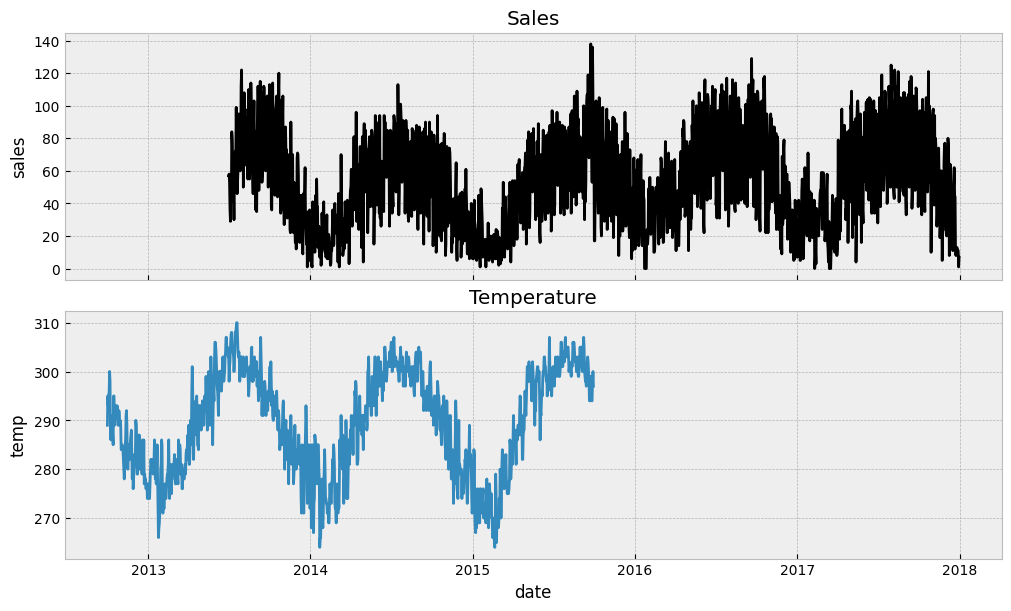

In [3]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), sharex=True, sharey=False, layout="constrained")
sns.lineplot(x="date", y="sales", data=raw_df, color="black", ax=ax[0])
sns.lineplot(x="date", y="temp", data=raw_df, color="C0", ax=ax[1])
ax[0].set(title="Sales")
ax[1].set(title="Temperature");

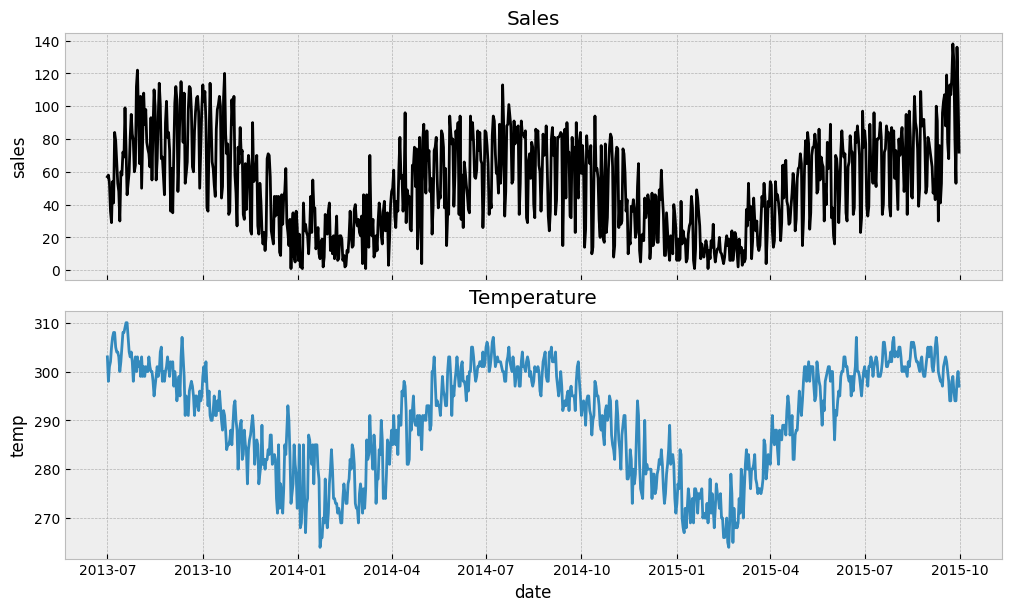

In [4]:
mask = "sales.notnull() and temp.notnull()"

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), sharex=True, sharey=False, layout="constrained")
sns.lineplot(x="date", y="sales", data=raw_df.query(mask), color="black", ax=ax[0])
sns.lineplot(x="date", y="temp", data=raw_df.query(mask), color="C0", ax=ax[1])
ax[0].set(title="Sales")
ax[1].set(title="Temperature");

In [5]:
df = (
    raw_df.query("temp.notnull()")
    .sort_values("date")
    .reset_index(drop=True)
    .eval(
        """
        temp_scaled = temp - temp.min()
        trend = (sales.index - 273 + 1) / 365.25
    """
    )
)

train_test_date = pd.to_datetime("'2013-10-15'")

df_train = df.query("date < @train_test_date & sales.notnull()")
df_test = df.query("date >= @train_test_date")

n_train = df_train.shape[0]
n_test = df_test.shape[0]
n = n_test + n_train

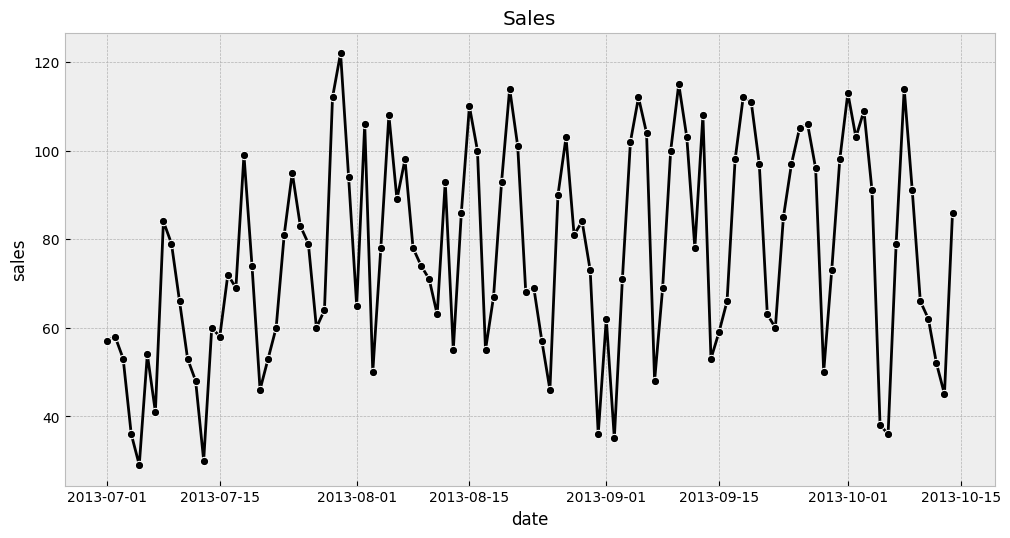

In [6]:
fig, ax = plt.subplots()
sns.lineplot(x="date", y="sales", data=df_train, color="black", marker="o", ax=ax)
ax.set(title="Sales");

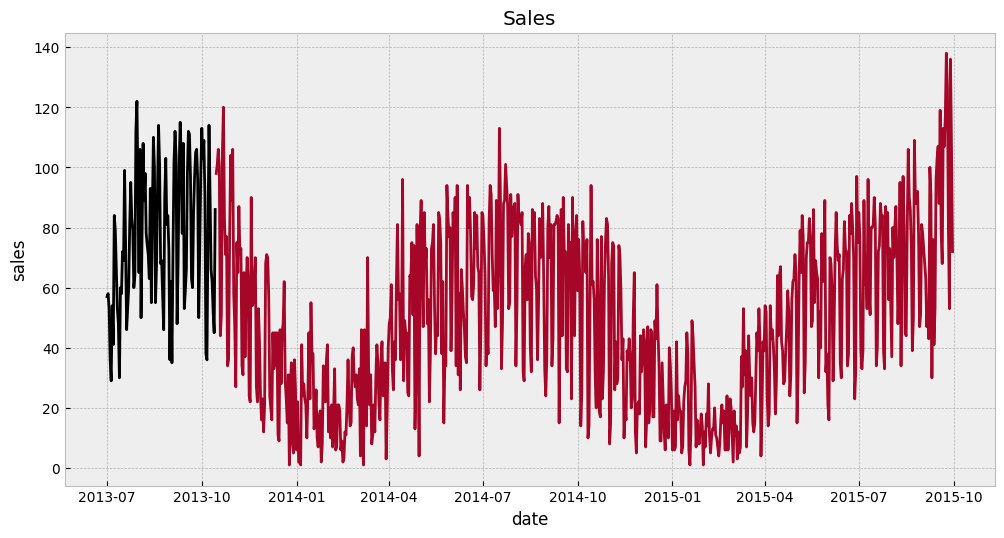

In [7]:
fig, ax = plt.subplots()
sns.lineplot(x="date", y="sales", data=df_train, color="black", ax=ax)
sns.lineplot(x="date", y="sales", data=df_test, color="C1", ax=ax)
ax.set(title="Sales");

## Temperature Model

In [8]:
date = df["date"]
temp_scaled = df["temp_scaled"]
trend = df["trend"]
sales = df["sales"]
dayofweek_idx, dayofweek = df["date"].dt.dayofweek.factorize()

In [9]:
periods = df["date"].dt.dayofyear / 365.25
n_order = 6

fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)

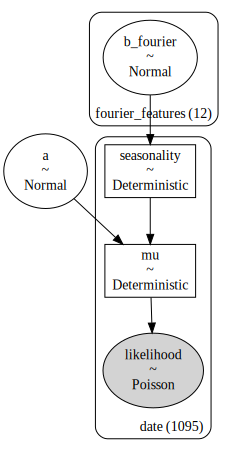

In [10]:
coords = {
    "date": date,
    "fourier_features": np.arange(2 * n_order),
}

with pm.Model(coords=coords) as temp_model:
    # --- priors ---
    ## intercept
    a = pm.Normal(name="a", mu=0, sigma=1)
    ## seasonality
    b_fourier = pm.Normal(name="b_fourier", mu=0, sigma=1, dims="fourier_features")
    # --- model parametrization ---
    seasonality = pm.Deterministic(
        "seasonality", pm.math.dot(b_fourier, fourier_features.to_numpy().T), dims="date"
    )
    mu = pm.Deterministic(name="mu", var= a + seasonality, dims="date")

    # --- likelihood ---
    pm.Poisson("likelihood", mu=pm.math.exp(mu), observed=temp_scaled, dims="date")

pm.model_to_graphviz(temp_model)

In [11]:
with temp_model:
    temp_prior_predictive = pm.sample_prior_predictive(samples=1000)

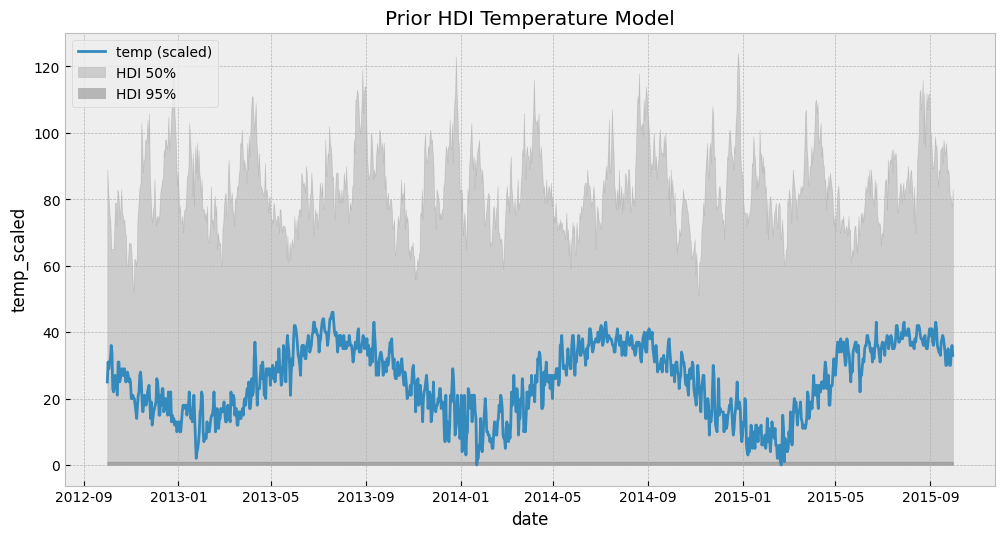

In [12]:
fig, ax = plt.subplots()

sns.lineplot(
    x="date", y="temp_scaled", data=df, color="C0", label="temp (scaled)", ax=ax
)
az.plot_hdi(
    x=date,
    y=temp_prior_predictive.prior_predictive["likelihood"],
    hdi_prob=0.95,
    color="gray",
    smooth=False,
    fill_kwargs={"label": "HDI 50%", "alpha": 0.3},
    ax=ax,
)
az.plot_hdi(
    x=date,
    y=temp_prior_predictive.prior_predictive["likelihood"],
    hdi_prob=0.5,
    color="gray",
    smooth=False,
    fill_kwargs={"label": "HDI 95%", "alpha": 0.5},
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(title="Prior HDI Temperature Model");

In [13]:
with temp_model:
    temp_idata = pm.sampling_jax.sample_numpyro_nuts(
        target_accept=0.9, draws=4000, chains=4
    )
    temp_posterior_predictive = pm.sample_posterior_predictive(trace=temp_idata)

Compiling...
Compilation time =  0:00:05.932121
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time =  0:00:04.037104
Transforming variables...
Transformation time =  0:00:00.159890
Computing Log Likelihood...
Log Likelihood time =  0:00:01.179823


In [14]:
az.summary(data=temp_idata, var_names=["a", "b_fourier"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,3.146,0.007,3.134,3.158,0.0,0.0,22764.0,13767.0,1.0
b_fourier[0],-0.248,0.009,-0.265,-0.231,0.0,0.0,22712.0,12948.0,1.0
b_fourier[1],-0.547,0.010,-0.566,-0.530,0.0,0.0,20319.0,13897.0,1.0
b_fourier[2],-0.122,0.010,-0.140,-0.104,0.0,0.0,19121.0,12794.0,1.0
b_fourier[3],-0.049,0.009,-0.067,-0.032,0.0,0.0,20692.0,13108.0,1.0
b_fourier[4],-0.046,0.009,-0.064,-0.029,0.0,0.0,19422.0,12837.0,1.0
b_fourier[5],0.047,0.009,0.029,0.064,0.0,0.0,21309.0,13660.0,1.0
b_fourier[6],-0.005,0.009,-0.022,0.013,0.0,0.0,21339.0,13169.0,1.0
b_fourier[7],0.046,0.009,0.029,0.063,0.0,0.0,23195.0,13304.0,1.0
b_fourier[8],-0.001,0.009,-0.018,0.017,0.0,0.0,23287.0,13300.0,1.0


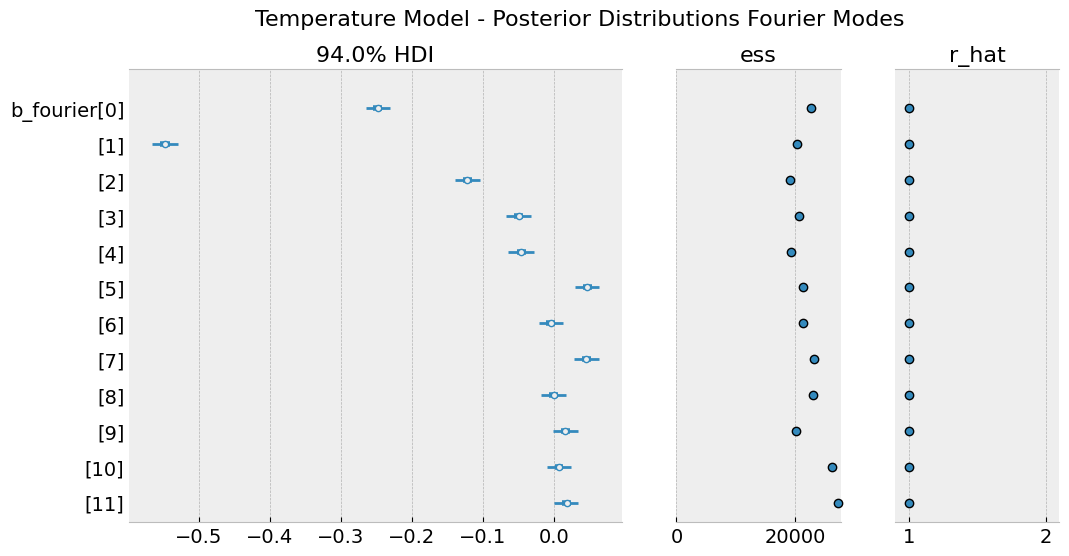

In [15]:
ax = az.plot_forest(
    data=temp_idata,
    var_names=["b_fourier"],
    combined=True,
    r_hat=True,
    ess=True,
    figsize=(12, 6),
)
plt.gcf().suptitle(
    "Temperature Model - Posterior Distributions Fourier Modes", fontsize=16
);

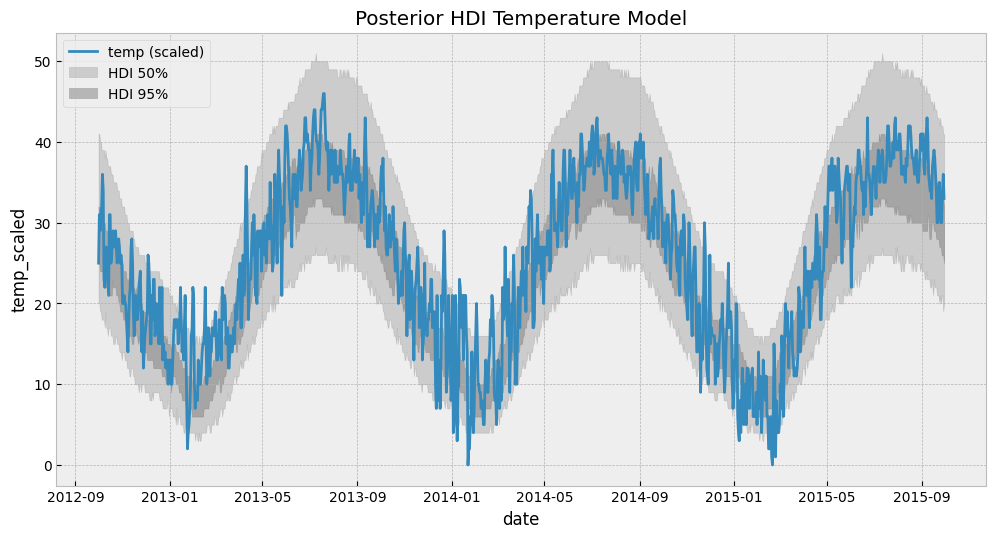

In [16]:
fig, ax = plt.subplots()

sns.lineplot(
    x="date", y="temp_scaled", data=df, color="C0", label="temp (scaled)", ax=ax
)
az.plot_hdi(
    x=date,
    y=temp_posterior_predictive.posterior_predictive["likelihood"],
    hdi_prob=0.95,
    color="gray",
    smooth=False,
    fill_kwargs={"label": "HDI 50%", "alpha": 0.3},
    ax=ax,
)
az.plot_hdi(
    x=date,
    y=temp_posterior_predictive.posterior_predictive["likelihood"],
    hdi_prob=0.5,
    color="gray",
    smooth=False,
    fill_kwargs={"label": "HDI 95%", "alpha": 0.5},
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(title="Posterior HDI Temperature Model");

## Sales Model

In [17]:
date_train = df_train["date"]
sales_train = df_train["sales"]
trend_train = df_train["trend"]
dayofweek_idx_train, dayofweek_train = df_train["date"].dt.dayofweek.factorize()

In [18]:
temp_model_summary = az.summary(data=temp_idata, var_names=["b_fourier"])
fourier_loc = temp_model_summary["mean"]
fourier_sd = temp_model_summary["sd"]

In [19]:
periods_train = df_train["date"].dt.dayofyear / 365.25
n_order = 6

fourier_features_train = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods_train * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)

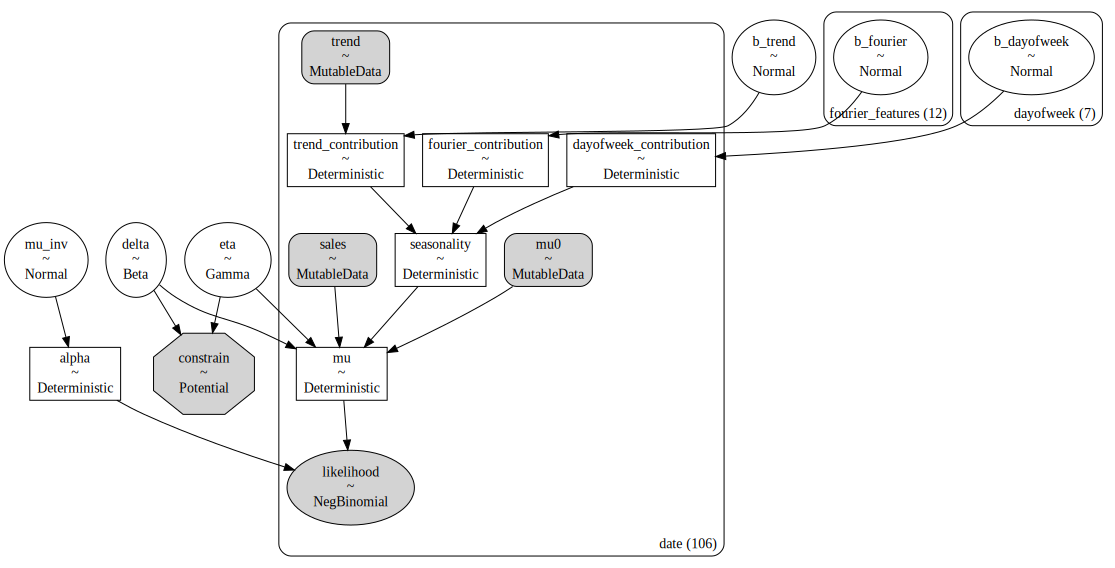

In [129]:
coords = {
    "fourier_features": np.arange(2 * n_order),
    "dayofweek": dayofweek_train,
}

with pm.Model(coords=coords) as sales_model:
    # --- data containers ---
    sales_model.add_coord(name="date", values=date_train, mutable=True)
    trend_data = pm.MutableData(name="trend", value=trend_train, dims="date")
    sales_data = pm.MutableData(name="sales", value=sales_train, dims="date")

    # --- priors ---
    delta = pm.Beta(name="delta", alpha=1, beta=10)
    eta = pm.Gamma(name="eta", alpha=0.5, beta=10)
    b_fourier = pm.Normal(
        name="b_fourier", mu=fourier_loc, sigma=fourier_sd, dims="fourier_features"
    )
    b_dayofweek = pm.Normal(name="b_dayofweek", mu=3, sigma=2, dims="dayofweek")
    b_trend = pm.Normal(name="b_trend", mu=0.03, sigma=0.02)
    alpha_inv = pm.Normal(name="mu_inv", mu=0, sigma=0.5)

    # --- model parametrization ---
    ## parameters constraints
    pm.Potential(name="constrain", var=at.switch(eta > 1 - delta, -np.inf, 0))
    # transferred trend and seasonality
    fourier_contribution = pm.Deterministic(
        name="fourier_contribution",
        var=pm.math.dot(b_fourier, fourier_features_train.to_numpy().T),
        dims="date",
    )
    dayofweek_contribution = pm.Deterministic(
        name="dayofweek_contribution", var=b_dayofweek[dayofweek_idx_train], dims="date"
    )
    trend_contribution = pm.Deterministic(
        name="trend_contribution", var=b_trend * trend_data, dims="date"
    )
    seasonality = pm.Deterministic(
        name="seasonality",
        var=pymc.math.exp(
            fourier_contribution + dayofweek_contribution + trend_contribution
        ),
        dims="date",
    )
    ## damped dynamic mean
    mu0 = pm.MutableData(
        name="mu0", value=np.zeros(sales_data.shape.eval()[0]), dims="date"
    )
    mu0 = at.set_subtensor(mu0[0], sales_data[0])

    def one_step(seasonality_t, sales_tm1, mu_tm1, delta, eta):
        return (1 - delta - eta) * seasonality_t + delta * mu_tm1 + eta * sales_tm1

    outputs, _ = aesara.scan(
        fn=one_step,
        sequences=[
            dict(input=seasonality[1:], taps=[0]),
            dict(input=sales_data, taps=[-1]),
        ],
        outputs_info=dict(initial=mu0, taps=[-1]),
        non_sequences=[delta, eta],
        strict=True,
    )
    mu = pm.Deterministic(
        name="mu", var=at.set_subtensor(mu0[1:], outputs[:, 0]), dims="date"
    )
    alpha = pm.Deterministic(name="alpha", var=1 / pm.math.sqr(alpha_inv))

    # --- likelihood ---
    pm.NegativeBinomial(
        name="likelihood", alpha=alpha, mu=mu, observed=sales_data, dims="date"
    )

pm.model_to_graphviz(sales_model)


In [130]:
# plt.plot(mu.eval())
# plt.plot(sales_train.reset_index(drop=True))

In [131]:
# alpha0 = at.zeros(sales_data.shape.eval()[0])
# alpha0 = at.set_subtensor(alpha0[0], sales_data[0])

# d = 0.51
# e = 0.5

# def one_step(seasonality_t, sales_tm1, alpha_tm1, delta, eta):
#     return (1 - delta - eta) * seasonality_t + delta * alpha_tm1 + eta * sales_tm1

# outputs, _ = aesara.scan(
#         fn=one_step,
#         sequences=[dict(input=seasonality[1:], taps=[-0]), dict(input=sales_data, taps=[-1])],
#         outputs_info=dict(initial=alpha0, taps=[-1]),
#         non_sequences=[delta, eta],
#         strict=True,
#     )

In [132]:
# one_step(seasonality[1], sales_data[0], alpha0[0], delta, eta).eval()
# alpha0 = at.set_subtensor(alpha0[1], one_step(seasonality[1], sales_data[0], alpha0[0], delta, eta).eval())
# one_step(seasonality[2], sales_data[1], alpha0[1], delta, eta).eval()
# alpha0 = at.set_subtensor(alpha0[2], one_step(seasonality[2], sales_data[1], alpha0[1], delta, eta).eval())
# one_step(seasonality[3], sales_data[2], alpha0[2], delta, eta).eval()
# alpha0.eval()

In [133]:
# alpha.eval()

In [134]:
# outputs.eval()

In [135]:
#outputs[: , 0].eval()

In [136]:
with sales_model:
    sales_prior_predictive = pm.sample_prior_predictive(samples=1000)

/var/folders/4r/dzmwyydj3mbggyfwbs1cklvh0000gn/T/ipykernel_72497/2852363265.py:2: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  sales_prior_predictive = pm.sample_prior_predictive(samples=1000)


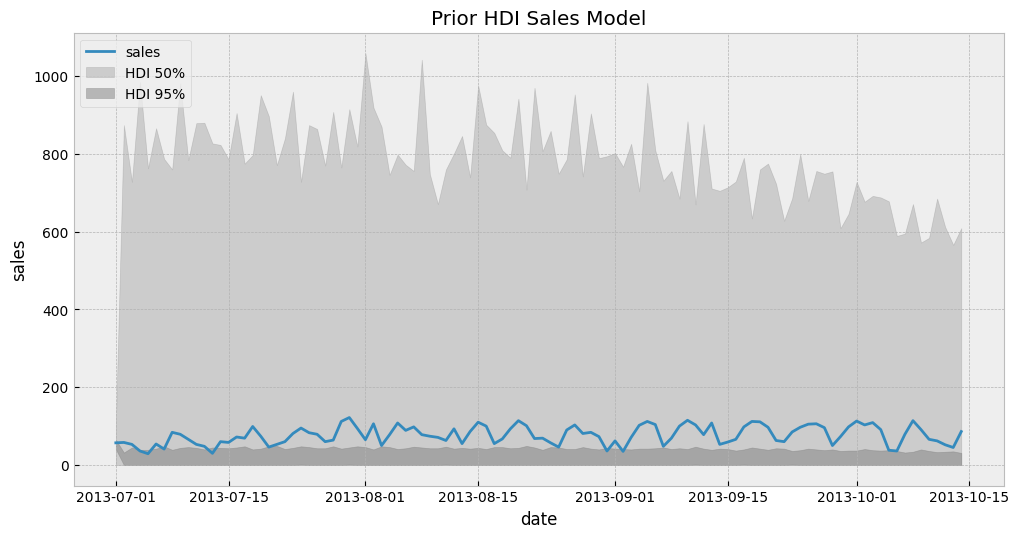

In [137]:
fig, ax = plt.subplots()

sns.lineplot(
    x="date", y="sales", data=df_train, color="C0", label="sales", ax=ax
)
az.plot_hdi(
    x=date_train,
    y=sales_prior_predictive.prior_predictive["likelihood"],
    hdi_prob=0.95,
    color="gray",
    smooth=False,
    fill_kwargs={"label": "HDI 50%", "alpha": 0.3},
    ax=ax,
)
az.plot_hdi(
    x=date_train,
    y=sales_prior_predictive.prior_predictive["likelihood"],
    hdi_prob=0.5,
    color="gray",
    smooth=False,
    fill_kwargs={"label": "HDI 95%", "alpha": 0.5},
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(title="Prior HDI Sales Model");

In [138]:
with sales_model:
    sales_idata = pm.sample(
        target_accept=0.95, draws=4_000, chains=4
    )
    sales_posterior_predictive = pm.sample_posterior_predictive(trace=sales_idata)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta, eta, b_fourier, b_dayofweek, b_trend, mu_inv]
INFO:pymc:NUTS: [delta, eta, b_fourier, b_dayofweek, b_trend, mu_inv]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 763 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 763 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/4r/dzmwyydj3mbggyfwbs1cklvh0000gn/T/ipykernel_72497/1303189139.py:5: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples

In [139]:
var_names = ["b_fourier", "b_dayofweek","b_trend", "delta", "eta", "alpha"]

In [140]:
az.summary(data=sales_idata, var_names=var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b_fourier[0],-0.250,0.009,-0.266,-0.232,0.000,0.000,13979.0,11605.0,1.0
b_fourier[1],-0.545,0.010,-0.564,-0.526,0.000,0.000,17840.0,13049.0,1.0
b_fourier[2],-0.122,0.010,-0.141,-0.103,0.000,0.000,15779.0,11138.0,1.0
b_fourier[3],-0.052,0.009,-0.069,-0.035,0.000,0.000,17027.0,11672.0,1.0
b_fourier[4],-0.044,0.009,-0.061,-0.027,0.000,0.000,16674.0,12429.0,1.0
b_fourier[5],0.049,0.009,0.032,0.066,0.000,0.000,17124.0,12077.0,1.0
b_fourier[6],-0.006,0.009,-0.023,0.011,0.000,0.000,19120.0,12982.0,1.0
b_fourier[7],0.046,0.009,0.029,0.063,0.000,0.000,16270.0,11886.0,1.0
b_fourier[8],-0.001,0.009,-0.018,0.016,0.000,0.000,15964.0,12018.0,1.0
b_fourier[9],0.017,0.009,0.001,0.034,0.000,0.000,17195.0,12071.0,1.0


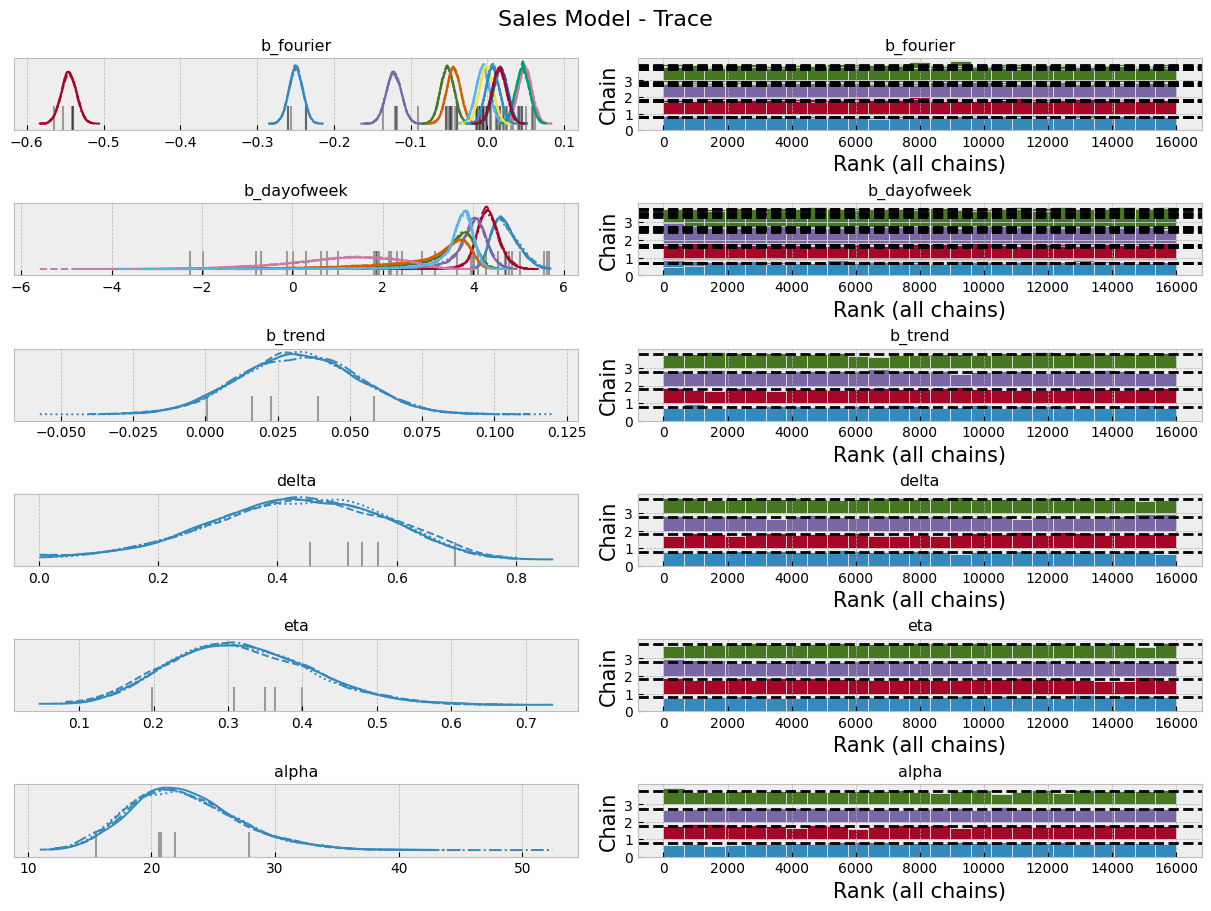

In [141]:
axes = az.plot_trace(
    data=sales_idata,
    var_names=var_names,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
plt.gcf().suptitle("Sales Model - Trace", fontsize=16);

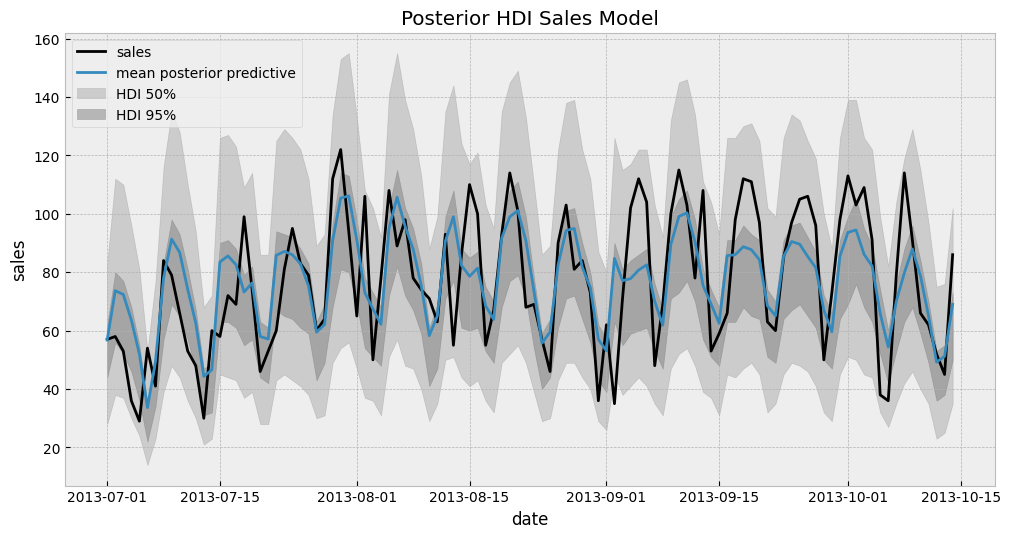

In [142]:
fig, ax = plt.subplots()

sns.lineplot(x="date", y="sales", data=df_train, color="black", label="sales", ax=ax)
sns.lineplot(
    x=date_train,
    y=sales_posterior_predictive.posterior_predictive["likelihood"]
    .stack(samples=("chain", "draw"))
    .mean(axis=1),
    color="C0",
    label="mean posterior predictive",
    ax=ax,
)
az.plot_hdi(
    x=date_train,
    y=sales_posterior_predictive.posterior_predictive["likelihood"],
    hdi_prob=0.95,
    color="gray",
    smooth=False,
    fill_kwargs={"label": "HDI 50%", "alpha": 0.3},
    ax=ax,
)
az.plot_hdi(
    x=date_train,
    y=sales_posterior_predictive.posterior_predictive["likelihood"],
    hdi_prob=0.5,
    color="gray",
    smooth=False,
    fill_kwargs={"label": "HDI 95%", "alpha": 0.5},
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(title="Posterior HDI Sales Model");


In [143]:
# with sales_model:
#     pm.set_data(new_data={"sales": sales}, coords={"date": date})
#     sales_idata.extend(
#         other=pm.sample_posterior_predictive(
#             trace=sales_idata,
#             var_names=["likelihood"],
#             idata_kwargs={"coords": {"date": date}},
#         ),
#         join="right",
#     )


In [144]:
posterior = sales_idata.posterior.stack(samples=("chain", "draw"))

In [146]:
seasonality_posterior = np.exp(
    posterior["b_trend"].to_numpy()[..., None] * trend[-n:][None, ...]
    + posterior["b_dayofweek"][dayofweek_idx[-n:]].T
    + np.tensordot(
        a=posterior["b_fourier"], b=fourier_features[-n:], axes=[[0], [1]]
    ).reshape(-1, n)
)

seasonality_posterior.shape

/var/folders/4r/dzmwyydj3mbggyfwbs1cklvh0000gn/T/ipykernel_72497/3918307190.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  posterior["b_trend"].to_numpy()[..., None] * trend[-n:][None, ...]


(16000, 822)

In [147]:
sales_train_posterior = sales_posterior_predictive.posterior_predictive[
    "likelihood"
].stack(samples=("chain", "draw")).T

sales_train_posterior.shape

(16000, 106)

In [150]:
n_samples = 4000 * 4

In [151]:
sales_posterior = np.zeros(shape=(n_samples, n))
sales_posterior[:, :n_train] = sales_train_posterior
sales_posterior.shape

(16000, 822)

In [153]:
mu_posterior = np.zeros(shape=(n_samples, n))
mu_posterior[:, :n_train] = posterior["mu"].T
mu_posterior.shape

(16000, 822)

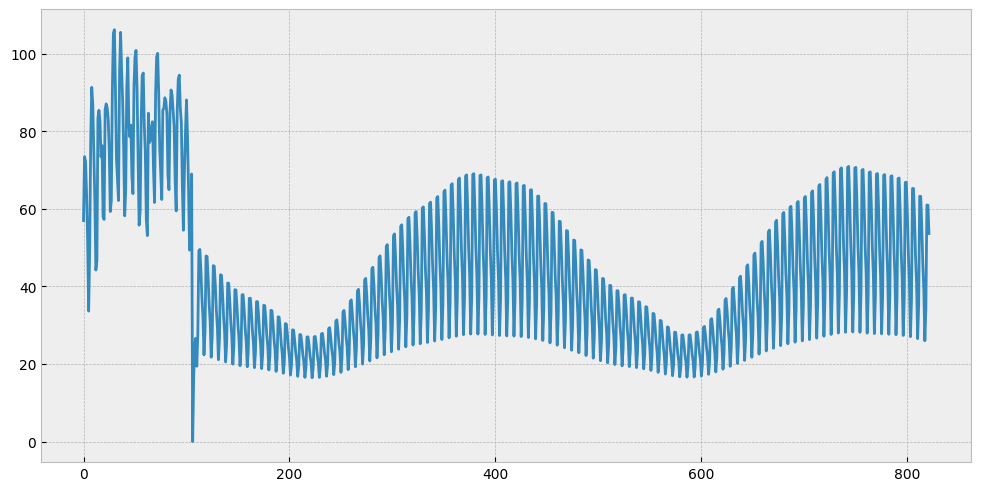

In [160]:
plt.plot(mu_posterior.mean(axis=0))

In [154]:
from tqdm.notebook import tqdm

for t in tqdm(range(n_train + 1, n)):
    
    mu_posterior[:, t] = (
        ((1 - posterior["delta"] - posterior["eta"]) * seasonality_posterior[:, t])
        + (posterior["delta"] * mu_posterior[:, t - 1])
        + (posterior["eta"] * sales_posterior[:, t - 1])
    )

    likelihood = pm.NegativeBinomial.dist(
        name="posterior_sales", alpha=mu_posterior[:, t], mu=posterior["alpha"].to_numpy()
    )

    sales_posterior[:, t] = pm.draw(likelihood)

  0%|          | 0/715 [00:00<?, ?it/s]

<AxesSubplot:>

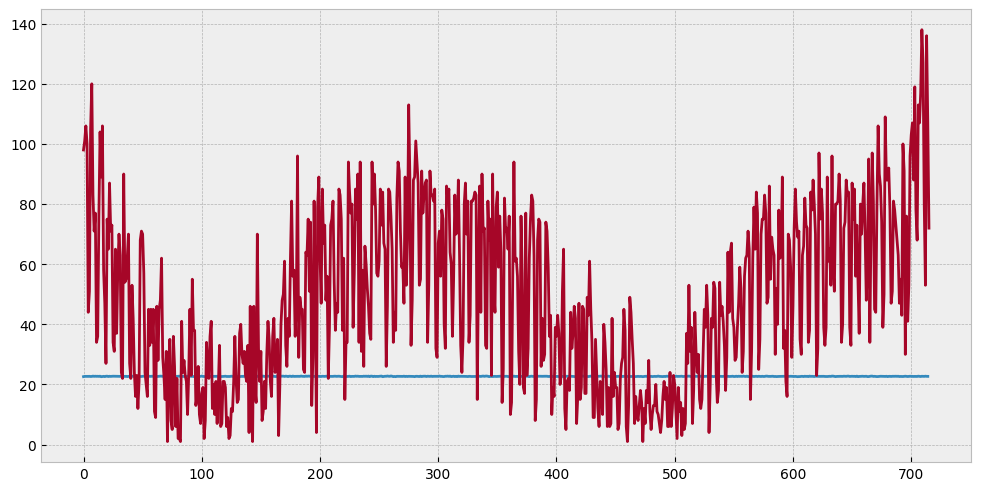

In [156]:
plt.plot(sales_posterior.mean(axis=0)[n_train + 1:])
df_test["sales"].reset_index(drop=True).plot()

/var/folders/4r/dzmwyydj3mbggyfwbs1cklvh0000gn/T/ipykernel_72497/638866827.py:1: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  sales_posterior_hdi95 = az.hdi(sales_posterior, hdi_prob=0.95)


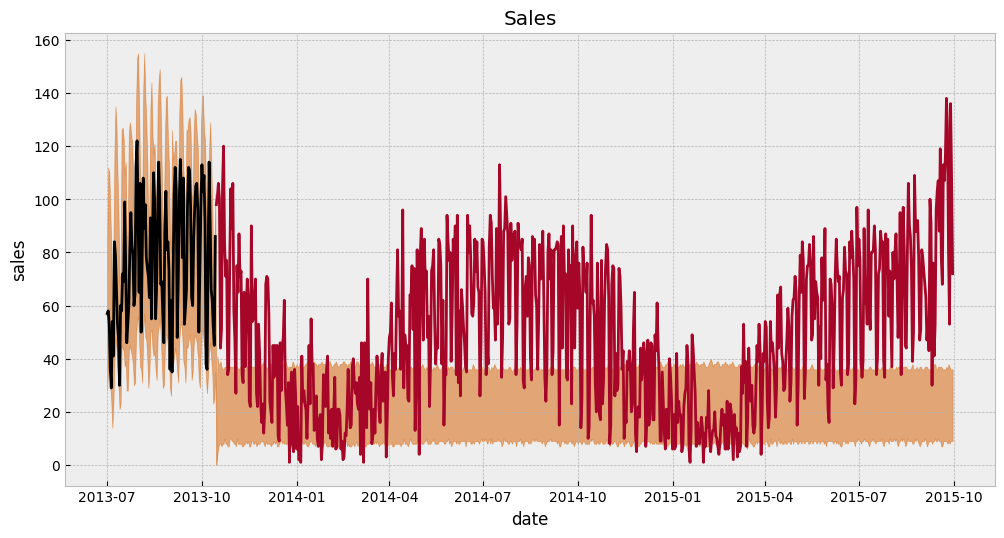

In [157]:
sales_posterior_hdi95 = az.hdi(sales_posterior, hdi_prob=0.95)

fig, ax = plt.subplots()

ax.fill_between(
    x=date[-n:],
    y1=sales_posterior_hdi95[:, 0],
    y2=sales_posterior_hdi95[:, 1],
    color="C4",
    alpha=0.5,
)
sns.lineplot(x="date", y="sales", data=df_train, color="black", ax=ax)
sns.lineplot(x="date", y="sales", data=df_test, color="C1", ax=ax)
ax.set(title="Sales");